In [69]:
%matplotlib notebook

In [70]:
import os
import dicom

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, moments
from skimage.morphology import closing, erosion, square
from skimage.draw import circle, circle_perimeter, circle_perimeter_aa
from skimage.feature import canny
from scipy.signal import medfilt
from scipy.optimize import fmin

def display_dicom(dcm,colormap='gray',colorbar=True):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    cax = ax.imshow(dcm.pixel_array,cmap=plt.get_cmap(colormap))

    if colorbar:
        fig.colorbar(cax)

def parse_dicom_tree(path):
    dcms = dict()
    for fn in os.listdir(path):
        ffn = os.path.join(path,fn)
        if os.path.isfile(ffn):
            try:
                ds = dicom.read_file(ffn)
                snum = ds.SeriesNumber
                if not snum in dcms:
                    dcms[snum] = list()
                dcms[snum].append(ds)
                
            except dicom.errors.InvalidDicomError:
                print("Skipping " + ffn + ", not a DICOM file")
    return dcms

def print_dicom_summary(dcms):
    series = sorted(dcms.keys())
    for s in series:
        print (str(dcms[s][0].SeriesNumber) + '\t' + str(len(dcms[s])) + '\t' + dcms[s][0].SeriesDescription)
        
def label_image(image, threshold_sensitivity=0.1,erosion_size=4):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > threshold_sensitivity*thresh, square(3))
    bw = erosion(bw, square(erosion_size))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = 0
    
    return label_image

def display_labels(label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(label_image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')

        
def display_labels_on_image(image,label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(image,cmap=plt.cm.gray)
    edges = np.nonzero(canny(labels.astype(np.float)))
    ax.plot(edges[1],edges[0],'.b',markersize=3)
    ax.axis('image')
    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')
        
def calc_flip_angle_map(dcm1,dcm2):
    if dcm1.FlipAngle > dcm2.FlipAngle:
        im_low = dcm2.pixel_array
        im_high = dcm1.pixel_array
        flip_angle_low = dcm2.FlipAngle
        flip_angle_high = dcm1.FlipAngle
    else:
        im_low = dcm1.pixel_array
        im_high = dcm2.pixel_array
        flip_angle_low = dcm1.FlipAngle
        flip_angle_high = dcm2.FlipAngle

    if flip_angle_high != 2*flip_angle_low:
        raise Exception('Low flip angle is not half of high flip angle')
    
    im_low = medfilt(im_low.astype(np.double),5)
    im_high = medfilt(im_high.astype(np.double),5)

    q = im_high/(2*(im_low+np.finfo(np.double).eps))
    q = np.clip(q,-1, 1);
    fa = np.arccos(q)*(180/np.pi);    
    
    #q = im_low/(im_high+np.finfo(np.double).eps)
    #q = np.clip(q,-1, 1);
    #fa = np.arcsin(q)*(180/np.pi);    

    fa = fa/flip_angle_low
    return fa

def get_label_mean(img,label_image,labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)
    
    means = list()
    for l in labels:
        m = (label_image == l).astype(np.double)
        s = np.sum(m*img)/np.sum(m)
        means.append(s)
        
    return means

def get_IR_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TIs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TIs[idx] = im.InversionTime
        
    idx = [i[0] for i in sorted(enumerate(TIs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TIs = TIs[idx]
    
    return TIs, signal

def fit_t1_mag_IR(TIs, IRSignal):
    #Doing 3 parameters fit
    # S = A - B exp(-TI./T1star)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = IRSignal[:,c]
        ss = sorted(enumerate(abs(s)), key=lambda x: x[1])
        if ss[0][0] == 0: 
            T1star = np.min(TIs)/np.log(2);
        else:
            tmp = ss[0:2]
            if tmp[0][0] > tmp[1][0]:
                tmp = [tmp[1], tmp[0]]
            slope = (tmp[1][1] + tmp[0][1])/(TIs[tmp[1][0]]-TIs[tmp[0][0]])
            T1star = (tmp[0][1]/slope + TIs[tmp[0][0]])/np.log(2)
        

        #Next let's do the fit with scipy.optimize.fmin (simplex)
        Ainit = np.max(np.abs(s))
        x0 = [Ainit, 2*Ainit, T1star] 
        costfcn = lambda x: np.sum((np.abs(x[0]-x[1]*np.exp(-TIs/x[2]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
        
    return fits

def get_SE_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TEs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TEs[idx] = im.EchoTime
        
    idx = [i[0] for i in sorted(enumerate(TEs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TEs = TEs[idx]
    
    return TEs, signal

def fit_t2_SE(TEs,signal):
    #Doing s parameters fit
    # S = A exp(-TE./T2)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = signal[:,c]
        y = np.log(np.abs(s))
        x = TEs;
        b = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)
        a = np.mean(y) - b*np.mean(x)
        x0 = [np.exp(a), -1/b]

        costfcn = lambda x: np.sum((np.abs(x[0]*np.exp(-TEs/x[1]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
    return fits

def imlist_to_pixel_array(imgs):
    img_size = imgs[0].pixel_array.shape
    img_array = np.zeros((len(imgs), img_size[0],img_size[1]))
    for idx, i in enumerate(imgs):
        img_array[idx,:,:] = i.pixel_array
    return img_array

def read_noise_covariance_matrix(filename):
    f = open(filename,'rb')
    xml_length = np.fromfile(f,dtype=np.uint32,count=1)
    xml_header = f.read(xml_length)
    noise_dwell_time = np.fromfile(f,dtype=np.float32,count=1)
    cov_length = np.fromfile(f,dtype=np.uint64,count=1)
    ndim = np.fromfile(f,dtype=np.uint64,count=1)
    dims = np.fromfile(f,dtype=np.uint64,count=ndim)
    cov_mtx = np.fromfile(f,dtype=np.complex64,count=np.prod(dims))
    cov_mtx = cov_mtx.reshape(dims)
    f.close()
    return cov_mtx

In [71]:
import csv
import re
f = open('/home/hansenms/data/PANDA/NIH_PANDA/DAY8_SPIRAL_SNR/DAT/filelist.csv', 'rt')
reader = csv.reader(f)
ssfp_spiral_scans = dict()
gre_spiral_scans = dict()
for row in reader:
    fname = row[0]
    scan_name = re.search('FID[0-9]{5}_([^.]+).dat',fname).group(1)
    scan_info = {'TR':float(row[1]), 'lines': int(row[2]), 'dwell_time': float(row[3]), 'samples': int(row[4]), 'flip': int(row[5])}
    scan_info['frame_time'] = scan_info['TR']*scan_info['lines']
    scan_info['sampling_time'] = scan_info['samples']*scan_info['dwell_time']/1000*scan_info['lines']
    scan_info['sampling_duty_cycle'] = scan_info['sampling_time']/scan_info['frame_time']
    if re.search('SGRE',scan_name):
        gre_spiral_scans[scan_name] = scan_info
    elif re.search('SPIR',scan_name):
        ssfp_spiral_scans[scan_name] = scan_info        
f.close()

In [72]:
ssfp_spiral_scans

{'SPIR_BW0475_TR1536_I8_F30': {'TR': 15.36,
  'dwell_time': 8.3,
  'flip': 30,
  'frame_time': 122.88,
  'lines': 8,
  'samples': 1620,
  'sampling_duty_cycle': 0.8753906250000001,
  'sampling_time': 107.56800000000001},
 'SPIR_BW0475_TR1536_I8_F50': {'TR': 15.36,
  'dwell_time': 8.3,
  'flip': 50,
  'frame_time': 122.88,
  'lines': 8,
  'samples': 1620,
  'sampling_duty_cycle': 0.8753906250000001,
  'sampling_time': 107.56800000000001},
 'SPIR_BW0475_TR1536_I8_F70': {'TR': 15.36,
  'dwell_time': 8.3,
  'flip': 70,
  'frame_time': 122.88,
  'lines': 8,
  'samples': 1620,
  'sampling_duty_cycle': 0.8753906250000001,
  'sampling_time': 107.56800000000001},
 'SPIR_BW0475_TR1536_I8_F90': {'TR': 15.36,
  'dwell_time': 8.3,
  'flip': 90,
  'frame_time': 122.88,
  'lines': 8,
  'samples': 1620,
  'sampling_duty_cycle': 0.8753906250000001,
  'sampling_time': 107.56800000000001},
 'SPIR_BW0510_TR1027_I12_F30': {'TR': 10.27,
  'dwell_time': 7.7,
  'flip': 30,
  'frame_time': 123.24,
  'lines': 1

In [73]:
d = parse_dicom_tree('/home/hansenms/data/PANDA/NIH_PANDA/DAY8_SPIRAL_SNR/DICOM')
print_dicom_summary(d)

24	50	SPIR_BW0890_TR0386_I32_F30__GT
25	1	SPIR_BW0890_TR0386_I32_F30__GT_SNR_MAP
26	50	SPIR_BW0890_TR0386_I32_F50__GT
27	1	SPIR_BW0890_TR0386_I32_F50__GT_SNR_MAP
28	50	SPIR_BW0890_TR0386_I32_F70__GT
29	1	SPIR_BW0890_TR0386_I32_F70__GT_SNR_MAP
30	50	SPIR_BW0890_TR0386_I32_F90__GT
31	1	SPIR_BW0890_TR0386_I32_F90__GT_SNR_MAP
32	50	SPIR_BW0670_TR0515_I24_F30__GT
33	1	SPIR_BW0670_TR0515_I24_F30__GT_SNR_MAP
34	50	SPIR_BW0670_TR0515_I24_F50__GT
35	1	SPIR_BW0670_TR0515_I24_F50__GT_SNR_MAP
36	50	SPIR_BW0670_TR0515_I24_F70__GT
37	1	SPIR_BW0670_TR0515_I24_F70__GT_SNR_MAP
38	50	SPIR_BW0670_TR0515_I24_F90__GT
39	1	SPIR_BW0670_TR0515_I24_F90__GT_SNR_MAP
40	50	SPIR_BW0550_TR0772_I16_F30__GT
41	1	SPIR_BW0550_TR0772_I16_F30__GT_SNR_MAP
42	50	SPIR_BW0550_TR0772_I16_F50__GT
43	1	SPIR_BW0550_TR0772_I16_F50__GT_SNR_MAP
44	50	SPIR_BW0550_TR0772_I16_F70__GT
45	1	SPIR_BW0550_TR0772_I16_F70__GT_SNR_MAP
46	50	SPIR_BW0550_TR0772_I16_F90__GT
47	1	SPIR_BW0550_TR0772_I16_F90__GT_SNR_MAP
48	50	SPIR_BW0475_TR1536_I8_

In [6]:
for sname in ssfp_spiral_scans:
    for series in d:
        r = re.search('([A-Z0-9_]+)__GT_SNR_MAP',d[series][0].SeriesDescription)
        if r and r.group(1) == sname:
            ssfp_spiral_scans[sname]['dicom_series'] = series 
            break
            
for sname in gre_spiral_scans:
    for series in d:
        r = re.search('([A-Z0-9_]+)__GT_SNR_MAP',d[series][0].SeriesDescription)
        if r and r.group(1) == sname:
            gre_spiral_scans[sname]['dicom_series'] = series 
            break

In [7]:
ssfp_spiral_snr_images = sorted([ssfp_spiral_scans[k]['dicom_series'] for k in ssfp_spiral_scans])
gre_spiral_snr_images = sorted([gre_spiral_scans[k]['dicom_series'] for k in gre_spiral_scans])

<IPython.core.display.Javascript object>


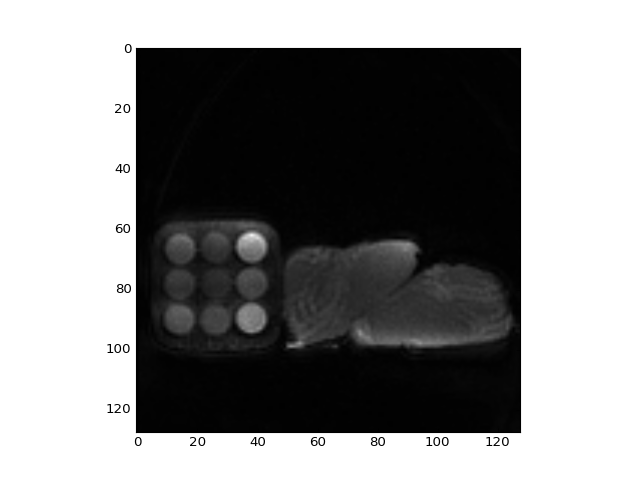

In [77]:
f, ax = plt.subplots(1,1)
img1 = ax.imshow(d[51][0].pixel_array,cmap=plt.cm.gray)

In [22]:
coords = []

def onclick(event):
    coords.append((event.xdata, event.ydata))

    if event.button == 3:
        f.canvas.mpl_disconnect(cid)

cid = f.canvas.mpl_connect('button_press_event', onclick)


In [23]:
coords

[(15.302083333333343, 66.40625),
 (26.968750000000007, 65.739583333333343),
 (38.302083333333336, 65.739583333333343),
 (14.302083333333343, 78.072916666666671),
 (26.302083333333336, 77.40625),
 (37.968750000000007, 77.40625),
 (14.302083333333343, 89.072916666666671),
 (26.302083333333336, 90.072916666666671),
 (37.635416666666679, 90.072916666666671),
 (78.96875, 73.072916666666671),
 (96.302083333333343, 86.072916666666671),
 (54.302083333333336, 74.072916666666671)]

In [9]:
stored_cords = [(15.302083333333343, 66.40625),
 (26.968750000000007, 65.739583333333343),
 (38.302083333333336, 65.739583333333343),
 (14.302083333333343, 78.072916666666671),
 (26.302083333333336, 77.40625),
 (37.968750000000007, 77.40625),
 (14.302083333333343, 89.072916666666671),
 (26.302083333333336, 90.072916666666671),
 (37.635416666666679, 90.072916666666671),
 (78.96875, 73.072916666666671),
 (96.302083333333343, 86.072916666666671),
 (54.302083333333336, 74.072916666666671)]

In [12]:
coords = stored_cords

In [13]:
radius = 3
labels = np.zeros(d[ssfp_spiral_snr_images[0]][0].pixel_array.shape,dtype=np.int)
for idx,c in enumerate(coords):
    cc,rr = circle(c[1],c[0],radius)
    labels[cc,rr] = idx+1

<IPython.core.display.Javascript object>


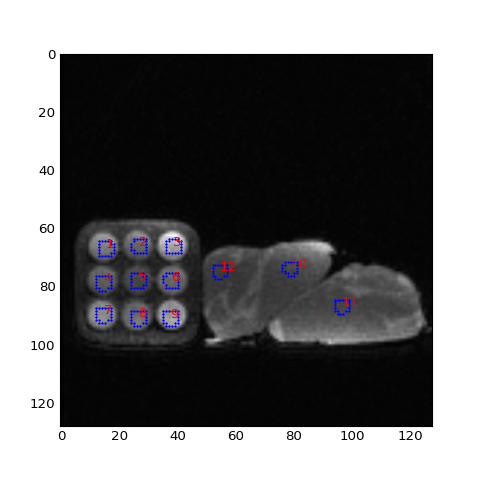

In [14]:
display_labels_on_image(d[ssfp_spiral_snr_images[0]][0].pixel_array,labels)

In [15]:
sample_times_cartesian = list()
regions_cartesian = list()

sample_times_spiral = list()
regions_spiral = list()
tr_spiral = list()
lines_spiral = list()
dwell_time_spiral = list()

for m in ssfp_spiral_scans:
    im_pixels = d[ssfp_spiral_scans[m]['dicom_series']][0].pixel_array
    mean_vals = get_label_mean(im_pixels,labels)
    ssfp_spiral_scans[m]['snr'] = mean_vals

for m in gre_spiral_scans:
    im_pixels = d[gre_spiral_scans[m]['dicom_series']][0].pixel_array
    mean_vals = get_label_mean(im_pixels,labels)
    gre_spiral_scans[m]['snr'] = mean_vals

In [16]:
def get_fa(scans,fa):
    subset = dict()
    for s in scans:
        if scans[s]['flip'] == fa:
            subset[s] = scans[s]
    return subset

<IPython.core.display.Javascript object>


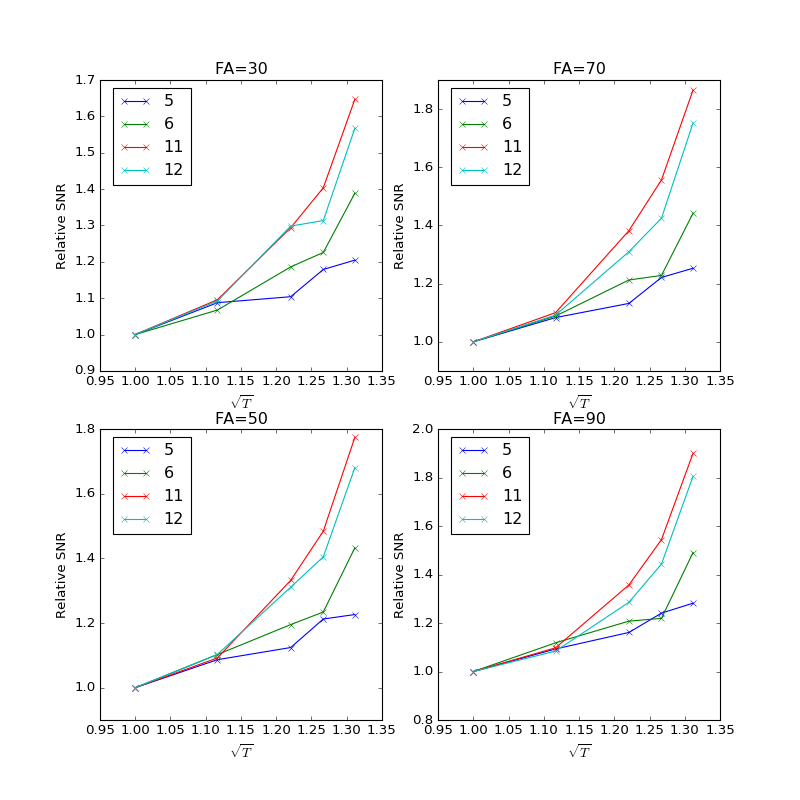

/home/hansenms/virtualenv/p3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
fas = [30,50,70,90]
scans = ssfp_spiral_scans
f,ax = plt.subplots(2,2,figsize=(10, 10))
samps = [4,5,10,11]
for fa_idx, fa in enumerate(fas):
    loc_ax = ax[fa_idx%2,fa_idx/2]
    handles = list()
    for r in samps:
        tmp = get_fa(scans,fa)
        t = [tmp[s]['sampling_time'] for s in tmp]
        snr = [tmp[s]['snr'][r] for s in tmp]
        order = [i[0] for i in sorted(enumerate(t), key=lambda x:x[1])]
        t = [t[i] for i in order]
        snr = [snr[i] for i in order]
        l = loc_ax.plot(np.sqrt(t)/np.sqrt(t[0]),snr/snr[0],'x-',label="%d"%(r+1))
        handles.append(l[0])
        loc_ax.set_title("FA=%d"%fa)
        loc_ax.set_xlabel('$\sqrt{T}$')
        loc_ax.set_ylabel('Relative SNR')
    loc_ax.legend(bbox_to_anchor=(0.35, 1.00))

<IPython.core.display.Javascript object>


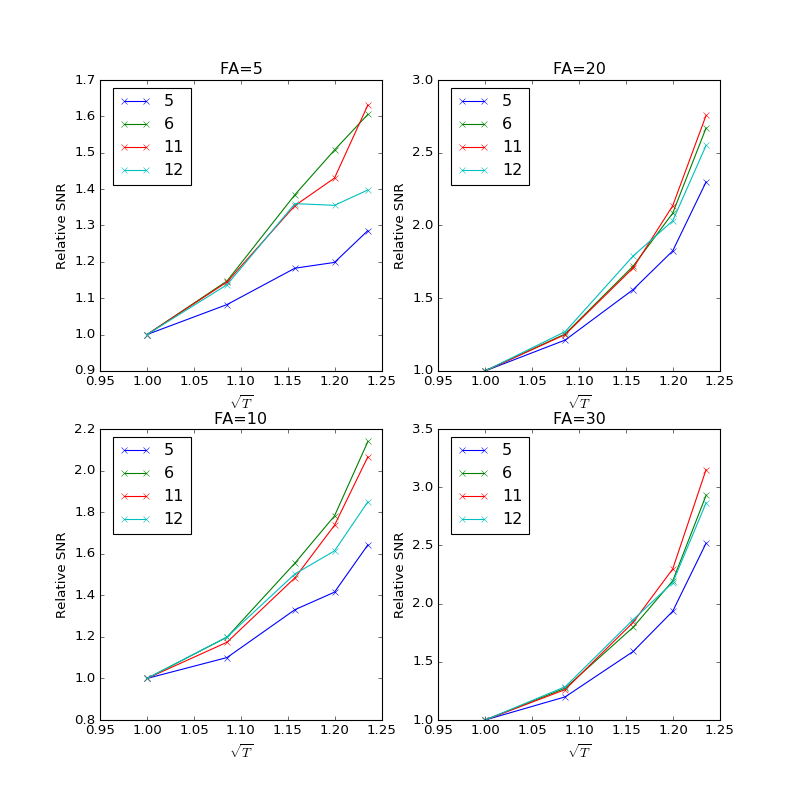

/home/hansenms/virtualenv/p3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [22]:
fas = [5,10,20,30]
scans = gre_spiral_scans
f,ax = plt.subplots(2,2,figsize=(10, 10))
samps = [4,5,10,11]
for fa_idx, fa in enumerate(fas):
    loc_ax = ax[fa_idx%2,fa_idx/2]
    handles = list()
    for r in samps:
        tmp = get_fa(scans,fa)
        t = [tmp[s]['sampling_time'] for s in tmp]
        snr = [tmp[s]['snr'][r] for s in tmp]
        order = [i[0] for i in sorted(enumerate(t), key=lambda x:x[1])]
        t = [t[i] for i in order]
        snr = [snr[i] for i in order]
        l = loc_ax.plot(np.sqrt(t)/np.sqrt(t[0]),snr/snr[0],'x-',label="%d"%(r+1))
        handles.append(l[0])
        loc_ax.set_title("FA=%d"%fa)
        loc_ax.set_xlabel('$\sqrt{T}$')
        loc_ax.set_ylabel('Relative SNR')
    loc_ax.legend(bbox_to_anchor=(0.35, 1.00))

In [45]:
tmp = get_fa(ssfp_spiral_scans,30)
d = {'T_acq': [tmp[s]['sampling_time'] for s in tmp],
     'int': [tmp[s]['lines'] for s in tmp],
     'TR': [tmp[s]['TR'] for s in tmp],
     'T_total': [tmp[s]['frame_time'] for s in tmp],
     'duty_cycle': [int(100*np.round(tmp[s]['sampling_duty_cycle'],2)) for s in tmp]}

In [54]:
from pandas import DataFrame
df = DataFrame(data=d)
df.sort_values('duty_cycle')

,TR,T_acq,T_total,duty_cycle,int
2,3.86,62.5152,123.52,51,32
3,5.15,77.9520,123.60,63,24
0,7.72,93.1520,123.52,75,16
1,10.27,100.3464,123.24,81,12
4,15.36,107.5680,122.88,88,8


In [55]:
tmp = get_fa(gre_spiral_scans,30)
d = {'T_acq': [tmp[s]['sampling_time'] for s in tmp],
     'int': [tmp[s]['lines'] for s in tmp],
     'TR': [tmp[s]['TR'] for s in tmp],
     'T_total': [tmp[s]['frame_time'] for s in tmp],
     'duty_cycle': [int(100*np.round(tmp[s]['sampling_duty_cycle'],2)) for s in tmp]}
df = DataFrame(data=d)
df.sort_values('duty_cycle')

,TR,T_acq,T_total,duty_cycle,int
3,3.79,70.5024,121.28,57,32
4,5.04,83.0304,120.96,69,24
0,7.49,94.4640,119.84,79,16
2,10.04,101.4624,120.48,84,12
1,15.03,107.5680,120.24,89,8


In [66]:
1-np.sqrt(1-1/7.12)

0.072880502956737092

In [65]:
1-np.sqrt(1-(1/4.52))

0.11752560266775858

In [64]:
np.sqrt(1-(1/4.52))/np.sqrt(1-1/7.12)

0.95184536637035244